# EDA on processed data to understand the dataset, and uncover patterns before using the data for modelling



In [12]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
sns.set_theme()

file_path = r"..\data\processed\cleaned-telco-customer-churn.csv"
df = pd.read_csv(file_path)


### Numerical Features

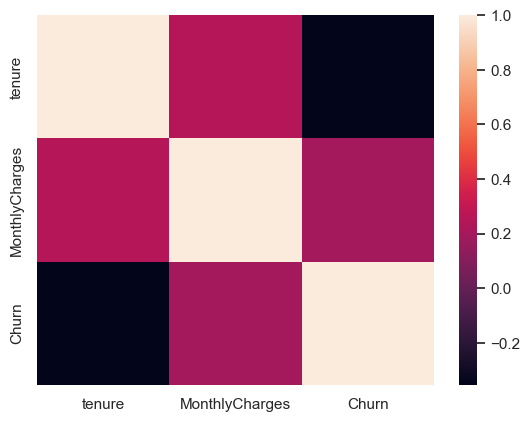

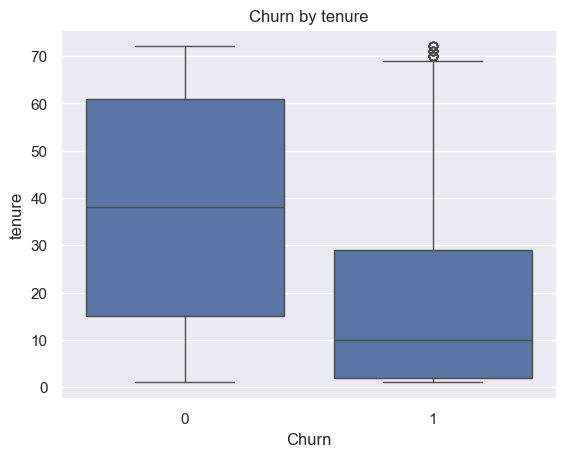

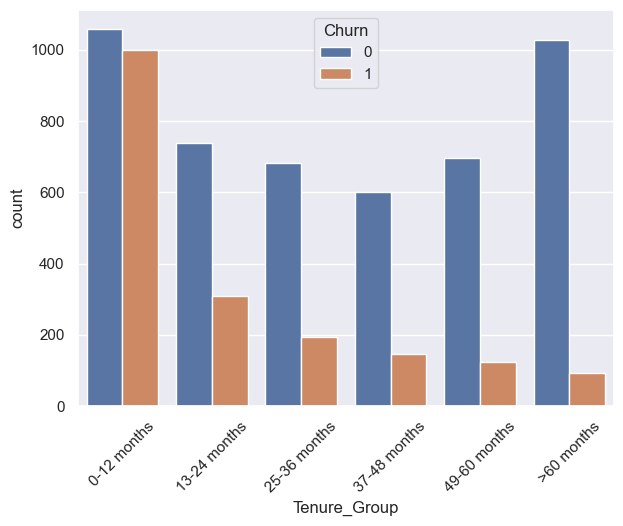

In [15]:
# Correlations 

numerical_features = ["tenure", "MonthlyCharges", "Churn"]
# numerical data frame
df_numerical = df[numerical_features]
corr_matrix = df_numerical.corr(numeric_only=True)
sns.heatmap(corr_matrix)
plt.show()

sns.boxplot(x="Churn", y="tenure", data=df_numerical)
plt.title("Churn by tenure")
plt.show()


# create bins of size 12 for tenure
bins = [0, 12, 24, 36, 48, 60, df['tenure'].max()]
labels = ['0-12 months', '13-24 months', '25-36 months', '37-48 months', '49-60 months', '>60 months']

# Create a new column for grouped tenure
df_numerical['Tenure_Group'] = pd.cut(df['tenure'], bins=bins, labels=labels, right=False)

sns.countplot(x="Tenure_Group", hue="Churn", data=df_numerical)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

1) Tenure and monthly charge has a correlation of 0.247 -> weak positive correlation, **suggesting customers with longer tenures tend to have slightly higher monthly charges**


2) Tenure and churn has a correlation of -0.354 -> moderate negative correlation, **suggesting customers with longer tenures are less likely to churn**
<br><br>*Exploring this correlation w/ 2 other graphs*<br><br>
    From the box plot:
    - Customers who did not churn have a wider range of tenures, with a median about 40 months. The IQR is broad, so many customers stayed for extended periods as tenure values are spread accross a long period.
    - Customers who churned have a lower median tenure, around 10 months. IQR is smaller so customers who churn will do so quickly. There are some outliers who have longer tenures but still churned, suggesitng long-term customers could be leaving due to other factors 

    From the count plot:
    - Churn rate decreases as tenure increases 

    Therefore, we can conclude, in general, **customers with longer tenures are less likely to churn**
<br>

3) Monthly charge and churn has a correlation of 0.193 -> weak positive correlation, **suggesting customers with higher monthly charges are slightly more likely to churn**